# Part 2: design a penalty function that enhances discrimination in the latent space

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
%matplotlib inline

import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torch.distributions import Categorical, Independent, Normal
from torch.distributions.mixture_same_family import MixtureSameFamily
from torch.utils.data.sampler import SubsetRandomSampler

from torchsummary import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(device))


cuda:0
NVIDIA GeForce RTX 3060 Ti


The order of presentation of samples is managed by the DataLoader and SubsetRandomSampler. The samples are randomly shuffled during training, which helps prevent the model from memorizing the order of data and aids in generalization.

In [2]:
# From pytorch dataset
kmnist_transform = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.1918,), (0.3483))]) ### 0.1918 and 0.3483 is the mean and standard deviation of the dataset in tensor format

train_dataset = datasets.KMNIST(root='./data', train=True, transform=kmnist_transform, download=True)
test_dataset = datasets.KMNIST(root='./data', train=False, transform=kmnist_transform, download=True) ### Set download to False if you have dataset

In [3]:
# Split train dataset for validation (10000 for validation, 50000 for training)
num_train = len(train_dataset)
indices = list(range(num_train))
val_size = 10000

val_idx = np.random.choice(indices, size=val_size, replace=False)
train_idx = list(set(indices) - set(val_idx))

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

In [4]:
# Create the dataloader 
batch_size = 100 
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          num_workers=2,
                          sampler=train_sampler) 

val_loader = DataLoader(train_dataset,
                        batch_size=batch_size,
                        num_workers=2,
                        sampler=val_sampler)

test_loader = DataLoader(test_dataset,
                         batch_size=len(test_dataset),
                         num_workers=2,
                         shuffle=True)

whole_train_loader = DataLoader(train_dataset,
                                batch_size=batch_size,
                                num_workers=2)

torch.Size([100, 1, 28, 28])


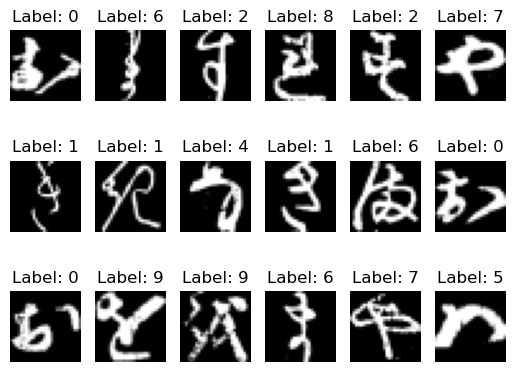

In [5]:
# Visualization of dataset
batch_idx, (data, target) = next(enumerate(train_loader, 0))
print(data.shape)

fig = plt.figure()
for i in range(18):
    plt.subplot(3, 6, i+1)
    plt.imshow(data[i][0], cmap='gray')
    plt.title('Label: {}'.format(target[i]))
    plt.axis(False)

In [10]:
# Define the Encoder with a Gaussian prior
# Encoder
class Encoder(nn.Module):
    
    def __init__(self, bottleneck_size):
        '''
        bottleneck_size: dimension of features we encode
        '''
        super(Encoder, self).__init__()
        self.encode_dim = bottleneck_size
        # Hidden layer
        self.fc1 = nn.Linear(784, 800) ### 28 x 28 = 784
        self.bn1 = nn.BatchNorm1d(800)
        self.fc2 = nn.Linear(800, 200)
        self.bn2 = nn.BatchNorm1d(200)
        self.fc3 = nn.Linear(200, bottleneck_size)
        
    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, -1)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x
    
    
# Decoder
class Decoder(nn.Module):
    
    def __init__(self, bottleneck_size):
        '''
        bottleneck_size: dimension of features we encode
        '''
        super(Decoder, self).__init__()
        self.encode_dim = bottleneck_size
        # Hidden layer
        self.fc1 = nn.Linear(bottleneck_size, 200)
        self.bn1 = nn.BatchNorm1d(200)
        self.fc2 = nn.Linear(200, 800)
        self.bn2 = nn.BatchNorm1d(800)
        self.fc3 = nn.Linear(800, 784)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        x = x.view(-1, 1, 28, 28)
        return x

# Autoencoder integrating Encoder and Decoder
class Autoencoder(nn.Module):
    def __init__(self, bottleneck_size):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(bottleneck_size)
        self.decoder = Decoder(bottleneck_size)

    def forward(self, x):
        encoded = self.encoder(x)
        reconstructed = self.decoder(encoded)
        return reconstructed

# Calculating constellation targets
def calculate_constellation_targets(model, train_loader):
    model.eval()
    targets = []
    with torch.no_grad():
        for data, target in train_loader:
            data = data.to(device)
            encoded = model.encoder(data)
            targets.append((target, encoded.clone().detach()))  
    # Calculating mean of encoded representations for each class
    constellation_targets = []
    for label in range(10):  # Assuming 10 classes in KMNIST
        class_samples = [item[1] for item in targets if (item[0] == label).any()]
        if len(class_samples) > 0:
            class_mean = torch.mean(torch.stack(class_samples), dim=0)
            constellation_targets.append(class_mean.cpu().numpy())
        else:
            # If no samples for the class, we append with zeros as placeholder
            constellation_targets.append(np.zeros_like(targets[0][1].cpu().numpy()))
    return np.array(constellation_targets)

# Calculating the distance between encoded samples and constellation targets
def euclidean_distance(x, y):
    return torch.sqrt(torch.sum((x - y)**2, dim=1))

def calculate_penalty(encoded, targets):
    distances = euclidean_distance(encoded, targets)
    return distances.mean()


Here, we've created a penalty function named calculate_penalty that computes the mean Euclidean distance between the encoded samples and their respective constellation targets.

The calculate_constellation_targets function computes the mean encoded representations for each class in the training set. These targets are used as a reference for the penalty function during training.

In [19]:
# Autoencoder model with specified parameters
model = Autoencoder(bottleneck_size=3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [20]:
# Calculation of constellation targets
num_classes = 10

Epoch [1/40] - Loss: 0.8924
Epoch [2/40] - Loss: 0.8084
Epoch [3/40] - Loss: 0.7913
Epoch [4/40] - Loss: 0.7526
Epoch [5/40] - Loss: 0.7444
Epoch [6/40] - Loss: 0.7384
Epoch [7/40] - Loss: 0.7333
Epoch [8/40] - Loss: 0.7266
Epoch [9/40] - Loss: 0.7157
Epoch [10/40] - Loss: 0.7044
Epoch [11/40] - Loss: 0.6963
Epoch [12/40] - Loss: 0.6898
Epoch [13/40] - Loss: 0.6842
Epoch [14/40] - Loss: 0.6809
Epoch [15/40] - Loss: 0.6759
Epoch [16/40] - Loss: 0.6722
Epoch [17/40] - Loss: 0.6687
Epoch [18/40] - Loss: 0.6659
Epoch [19/40] - Loss: 0.6631
Epoch [20/40] - Loss: 0.6612
Epoch [21/40] - Loss: 0.6587
Epoch [22/40] - Loss: 0.6562
Epoch [23/40] - Loss: 0.6547
Epoch [24/40] - Loss: 0.6535
Epoch [25/40] - Loss: 0.6513
Epoch [26/40] - Loss: 0.6498
Epoch [27/40] - Loss: 0.6484
Epoch [28/40] - Loss: 0.6470
Epoch [29/40] - Loss: 0.6461
Epoch [30/40] - Loss: 0.6453
Epoch [31/40] - Loss: 0.6440
Epoch [32/40] - Loss: 0.6429
Epoch [33/40] - Loss: 0.6407
Epoch [34/40] - Loss: 0.6406
Epoch [35/40] - Loss: 0

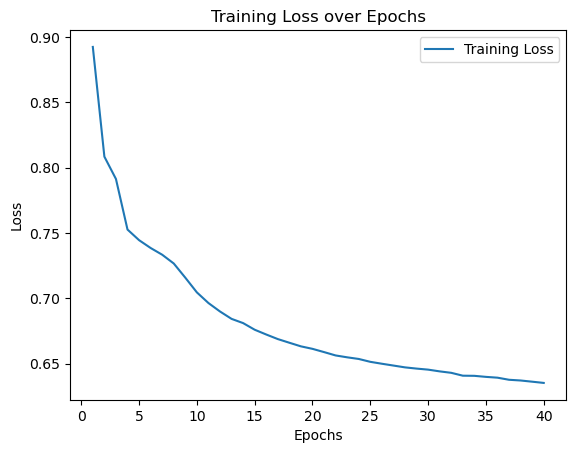

In [21]:
# Training loop with loss logging
epochs = 40
loss_values = []  # To store the loss values for plotting

# Training loop with modified loss function
lambda_value = 0.1

torch.manual_seed(8)
for epoch in range(epochs):
    model = model.to(device)
    model.train()
    running_loss = 0.0
    
    constellation_targets = calculate_constellation_targets(model, train_loader)
    constellation_targets = torch.tensor(constellation_targets, dtype=torch.float32, device=device)
    
    
    for data, labels in train_loader:
        data = data.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(data)
        loss = criterion(outputs, data)

        encoded = model.encoder(data)
        penalty = calculate_penalty(encoded, constellation_targets[labels])

        total_loss = loss + lambda_value * penalty

        total_loss.backward()
        optimizer.step()

        running_loss += total_loss.item()

    epoch_loss = running_loss / len(train_loader)
    loss_values.append(epoch_loss)
    print(f"Epoch [{epoch + 1}/{epochs}] - Loss: {epoch_loss:.4f}")

# Save the trained model
# torch.save(model.state_dict(), 'autoencoder_model.pth')

# Plotting the loss values
plt.plot(range(1, epochs + 1), loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

lambda_value is the hyperparameter that determines the influence of the regularization term (penalty) on the overall loss. It's a tuning parameter that can be adjusted to balance reconstruction and discrimination objectives.

The batch size K is implicitly handled by the train_loader during the training loop. It iterates through the dataset in batches, and within each iteration, the penalty is calculated based on the batch size used.

The penalty is integrated into the total loss calculation within the training loop. It's combined with the reconstruction loss using the defined lambda value to update the model parameters through backpropagation.

In [22]:
# Visualization of Reconstructed Images
# Define 3D visualization of latent space
def latent_3d_plot(encoder, name, test_loader = test_loader, download=True):
    idx, (img, target) = next(enumerate(test_loader))
    img = img.to(device)
    with torch.no_grad():
        target = target.to(device).cpu().numpy()

        bottleneck = encoder(img).cpu().numpy()
        # Create a 3D subplot

        fig = plt.figure(figsize=(5, 10))
        ax = fig.add_subplot(111, projection='3d')
        x = bottleneck[:, 0]
        y = bottleneck[:, 1]
        z = bottleneck[:, 2]
        ax.set_title(name)
        # Scatter plot
        ax.scatter(x, y, z, c=target, cmap=plt.cm.gist_rainbow, label=target, s=10)
    if download:
        plt.savefig('./figure/{}.png'.format(name))

def visualize_reconstructed_images(model, test_loader, num_images=10):
    model.eval()
    with torch.no_grad():
        for data, _ in test_loader:
            output = model(data)
            reconstructed_images = output.cpu().numpy()[:num_images]
            original_images = data.cpu().numpy()[:num_images]

            fig, axes = plt.subplots(2, num_images, figsize=(20, 4))

            for i in range(num_images):
                axes[0, i].imshow(original_images[i][0], cmap='gray')
                axes[0, i].axis('off')
                axes[0, i].set_title('Original')

                axes[1, i].imshow(reconstructed_images[i][0], cmap='gray')
                axes[1, i].axis('off')
                axes[1, i].set_title('Reconstructed')

            plt.tight_layout()
            plt.show()
            break

# visualize_reconstructed_images(model, test_loader)

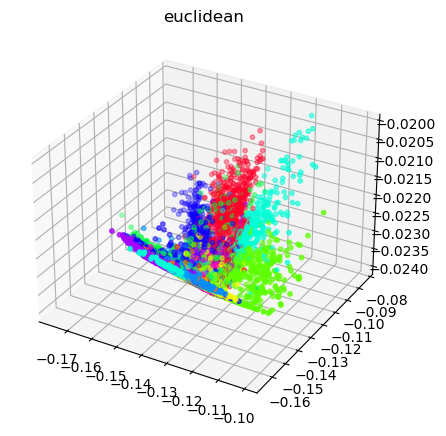

In [23]:
latent_3d_plot(model.encoder, name='euclidean')

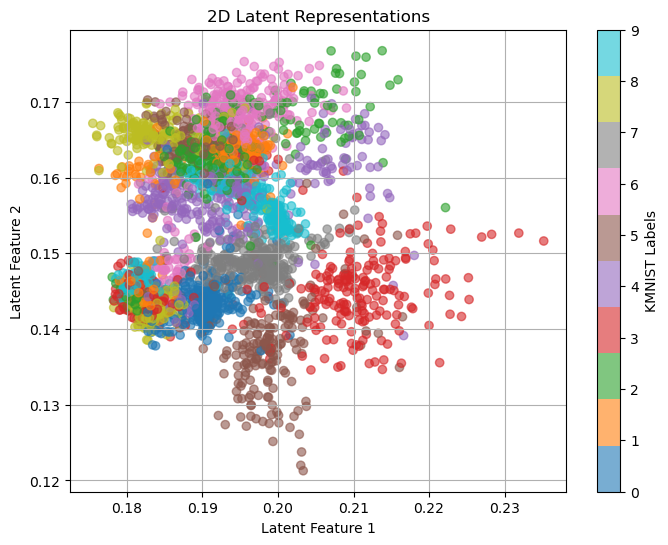

In [12]:
# Collecting latent representations for visualization
latent_representations = []
labels = []

model.eval()
with torch.no_grad():
    for data, target in whole_train_loader:
        data = data.to(device)
        encoded = model.encoder(data)
        latent_representations.append(encoded.cpu().numpy())
        labels.append(target.cpu().numpy())

latent_representations = np.concatenate(latent_representations, axis=0)
labels = np.concatenate(labels, axis=0)

# Visualizing on a 2D scatter plot (considering only a subset for better visualization)
subset_indices = np.random.choice(len(latent_representations), size=3000, replace=False)
subset_representations = latent_representations[subset_indices]
subset_labels = labels[subset_indices]

plt.figure(figsize=(8, 6))
plt.scatter(subset_representations[:, 0], subset_representations[:, 1], c=subset_labels, cmap='tab10', alpha=0.6)
plt.colorbar(label='KMNIST Labels')
plt.title('2D Latent Representations')
plt.xlabel('Latent Feature 1')
plt.ylabel('Latent Feature 2')
plt.grid(True)
plt.show()

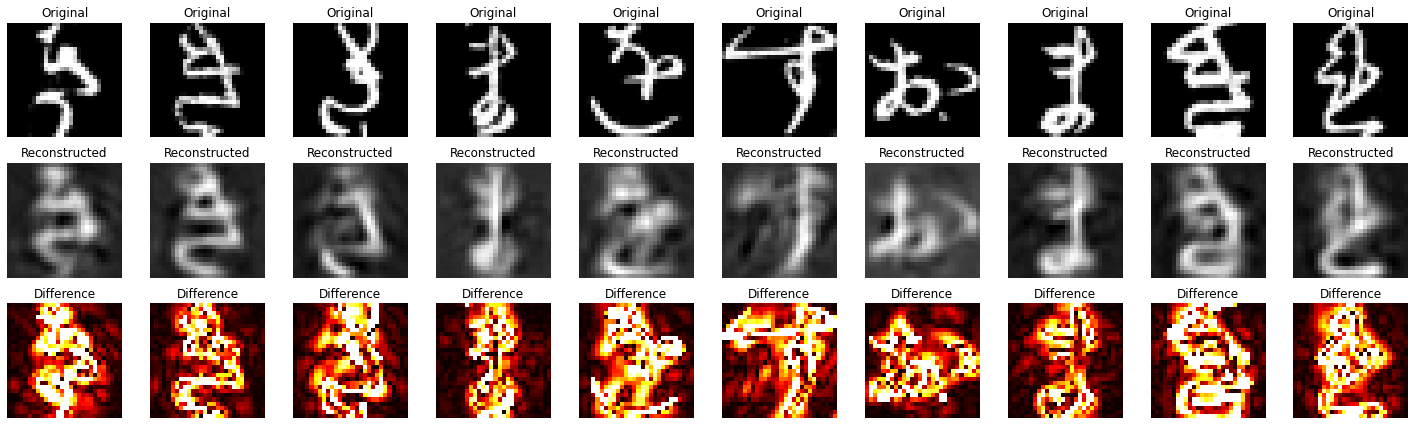

In [12]:
# Function to visualize original, reconstructed, and difference images
def visualize_reconstruction_comparison(model, test_loader, num_images=10):
    model.eval()
    with torch.no_grad():
        for data, _ in test_loader:
            output = model(data.to(device))
            reconstructed_images = output.cpu().numpy()[:num_images]
            original_images = data.cpu().numpy()[:num_images]

            fig, axes = plt.subplots(3, num_images, figsize=(20, 6))

            for i in range(num_images):
                # Plot original images
                axes[0, i].imshow(original_images[i][0], cmap='gray')
                axes[0, i].axis('off')
                axes[0, i].set_title('Original')

                # Plot reconstructed images
                axes[1, i].imshow(reconstructed_images[i][0], cmap='gray')
                axes[1, i].axis('off')
                axes[1, i].set_title('Reconstructed')

                # Calculate and plot the difference between original and reconstructed
                difference = np.abs(original_images[i][0] - reconstructed_images[i][0])
                axes[2, i].imshow(difference, cmap='hot', vmin=0, vmax=1)
                axes[2, i].axis('off')
                axes[2, i].set_title('Difference')

            plt.tight_layout()
            plt.show()
            break  # Show only the first batch of images

visualize_reconstruction_comparison(model, test_loader, num_images=10)


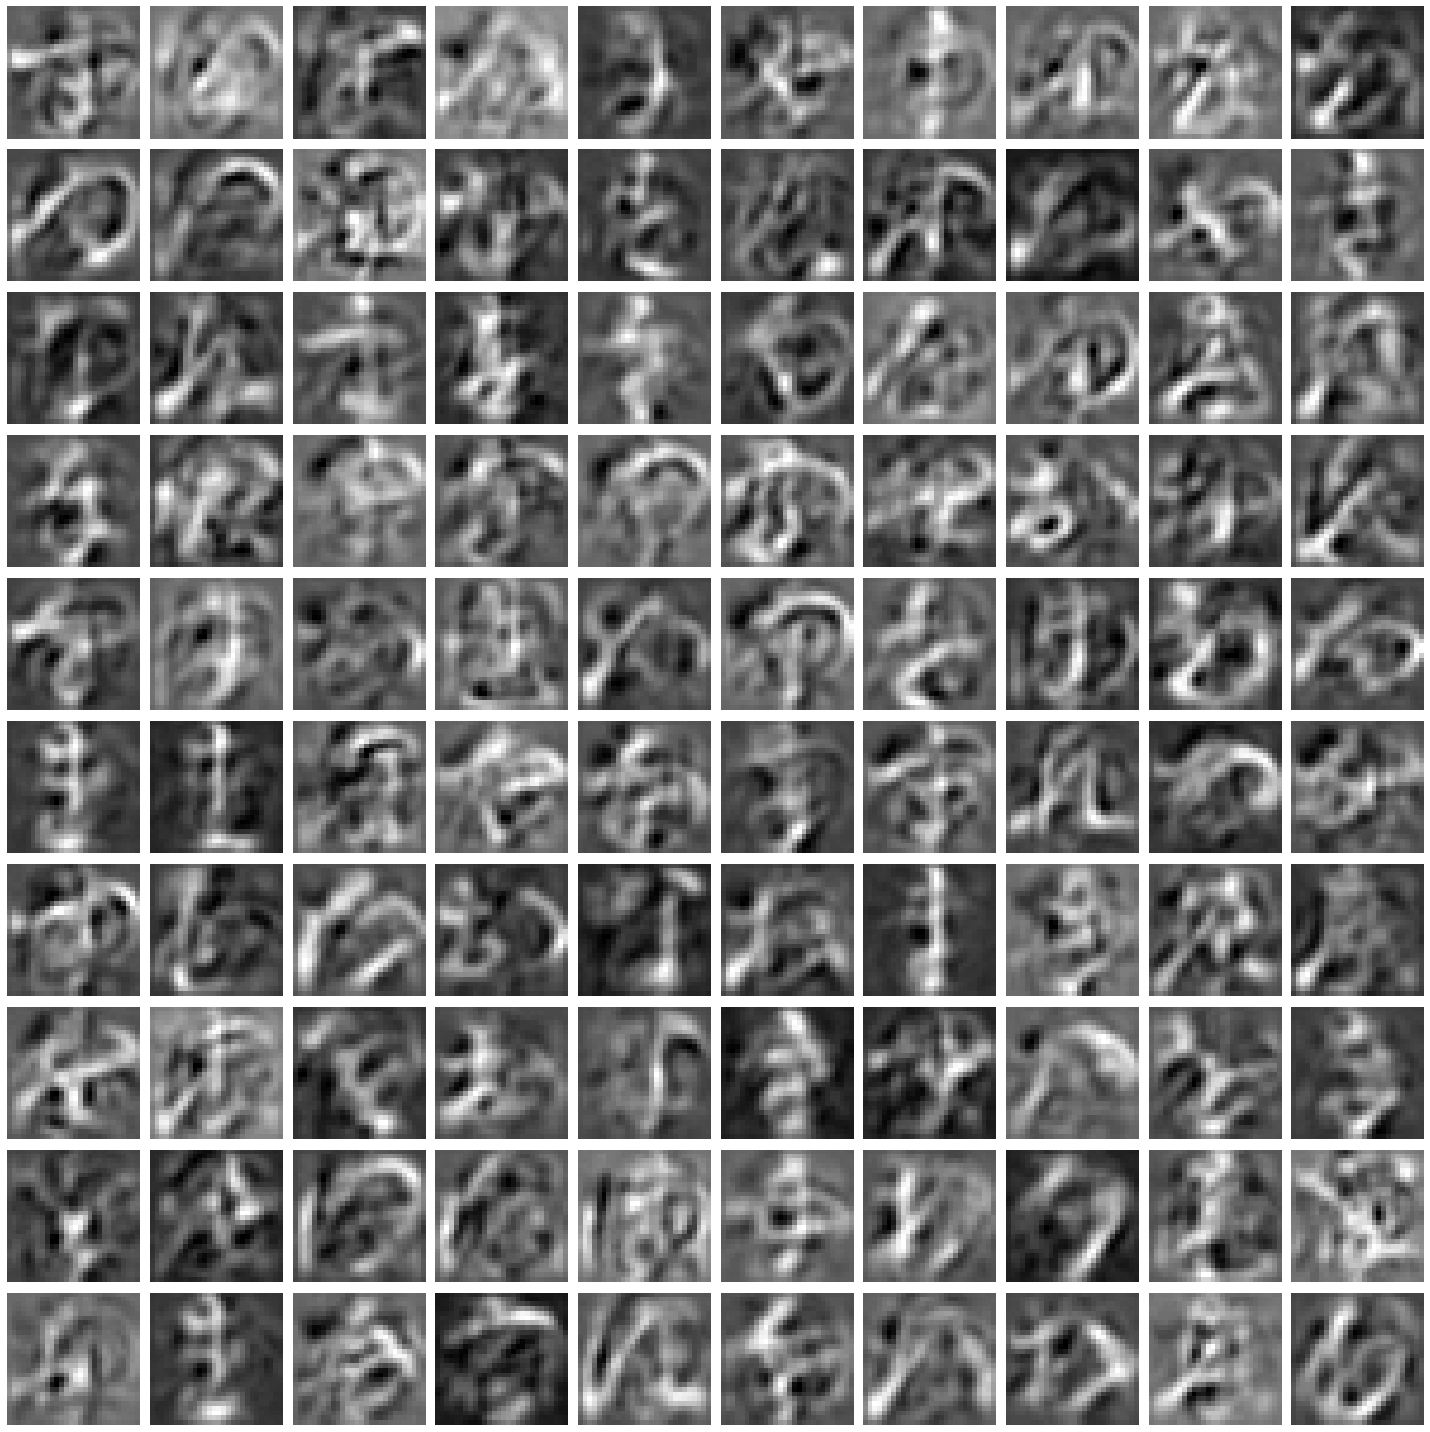

In [13]:
import torch
# Generate random points in the latent space
latent_size = 60 
num_samples = 100

# Generate random points from a normal distribution
random_latent_points = torch.randn(num_samples, latent_size).to(device)

# Decode the random points to generate samples
with torch.no_grad():
    decoded_samples = model.decoder(random_latent_points)

# Visualize the generated samples
plt.figure(figsize=(20, 20))
for i in range(num_samples):
    plt.subplot(10, 10, i + 1)
    plt.imshow(decoded_samples[i].cpu().numpy().reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()